<a href="https://colab.research.google.com/github/hseyeon1006/ESAA_OB/blob/%ED%95%84%EC%82%AC/Chap04_HW0911.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Chap4. 모델 훈련

##4.1 선형 회귀

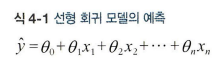

* yhat : 예측값
* n : 특성의 수
* xi : i번째 특성값
* thetaj : j번째 모델 파라미터

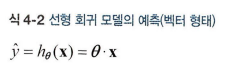
* theta : 편향 theta0에서 thetan까지의 특성 가중치를 담은 모델의 파라미터 벡터
* x : x0에서 xn까지 담은 샘플의 특성 벡터임. x0는 항상 1임
* theta*x : 벡터 theta와 x의 점곱임. 이는 theta0x0+theta1x1+...+thetanxn와 같음
* htheta : 모델 파라미터 theta를 사용한 가설 함수

선형 회귀 모델을 훈련시키려면 RMSE를 최소화하는 theta를 찾아야함. 실제로는 RMSE보다 평균 제곱 오차를 최소화하는 것이 같은 결과를 내면서 더 간단함

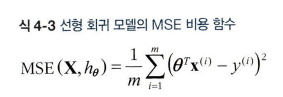

###4.1.1. 정규방정식

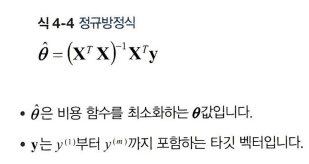

In [1]:
import warnings
warnings.filterwarnings('ignore')

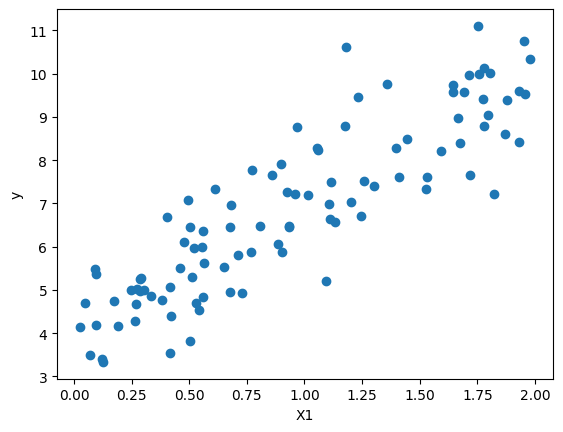

In [2]:
# 위 공식을 테스트하기 위해 선형처럼 보이는 데이터 생성
import numpy as np
import matplotlib.pyplot as plt

X = 2 * np.random.rand(100,1)
y = 4 + 3 * X + np.random.randn(100,1)
plt.scatter(X,y)
plt.xlabel('X1')
plt.ylabel('y')
plt.show()

In [3]:
#정규방정식 사용해 thetahat 계산
X_b = np.c_[np.ones((100,1)), X]  # 모든 샘플에 x0 = 1을 추가합니다.
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [4]:
theta_best

array([[4.06799927],
       [2.95944954]])

In [5]:
#thetahat을 사용해 예측
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2,1)), X_new]  # 모든 샘플에 x0 = 1을 추가합니다.
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.06799927],
       [9.98689835]])

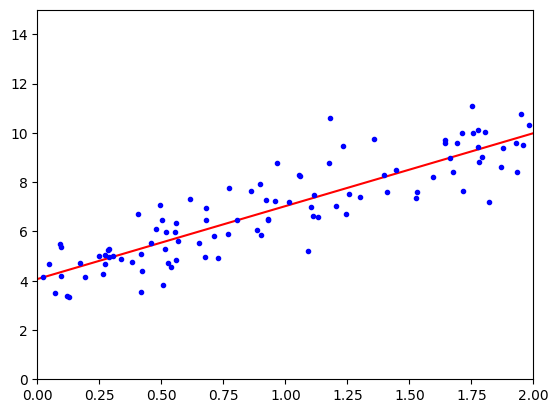

In [6]:
#모델의 예측을 그래프에 나타내기
import matplotlib.pyplot as plt

plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

In [7]:
#사이킷런에서 선형 회귀 수행
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_
lin_reg.predict(X_new)

array([[4.06799927],
       [9.98689835]])

In [8]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.06799927],
       [2.95944954]])

thetahat = X+*y를 계산함

X+ : X의 유사역행렬

In [9]:
#유사 역행렬 직접 구하기
np.linalg.pinv(X_b).dot(y)

array([[4.06799927],
       [2.95944954]])

유사역행렬 자체는 특잇값 분해 (SVD)라 부르는 표준 행렬 분해 기법 사용해 계산됨

###4.1.2. 계산 복잡도

* 역행렬을 계산하는 계산 복잡도는 일반적으로 O(n^2.4)에서 O(n^3) 사이임.
* 특성 수가 두 배로 늘어나면 계산 시간이 대략 5.3에서 8배로 증가함
* 정규방정식이나 다른 알고리즘으로 학습된 선형 회귀 모델은 예측이 매우 빠름
* 예측 계산도 복잡도는 샘플 수와 특성 수에 선형적임
* 즉 예측하려는 샘플이 두 배로 늘어나면 걸리는 시간도 거의 두 배 증가함

##4.2. 경사 하강법

* 경사하강법(GD) : 여러 종류의 문제에서 최적의 해법을 찾을 수 있는 일반적인 최적화 알고리즘임
* 기본 아이디어 : 비용 함수를 최소화하기 위해 반복해서 파라미터를 조정해가는 것임
* 파라미터 벡터 theta : 비용 함수의 현재 그래디언트를 계산함. 그래디언트가 감소하는 방향으로 진행함. 그래디언트가 0이 되면 최솟값에 도달한 것임

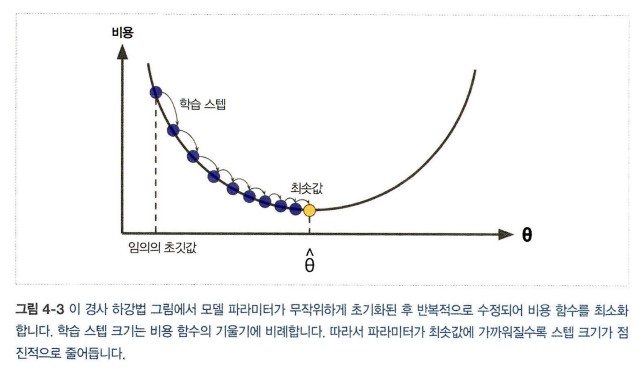

* 학습률 : 경사하강법에서 중요한 파라미터인 스텝의 크기임. 학습률이 너무 작으면 알고리즘이 수렴하기 위해 반복을 많이 진행해야하므로 시간이 오래 걸림

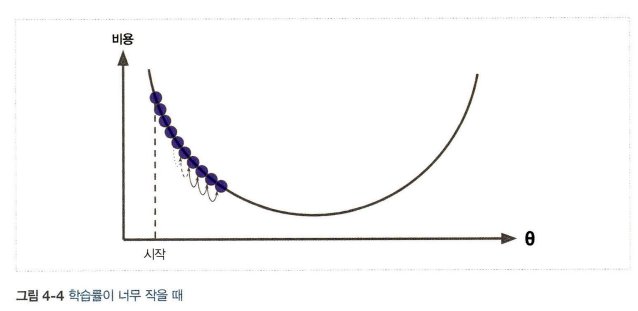

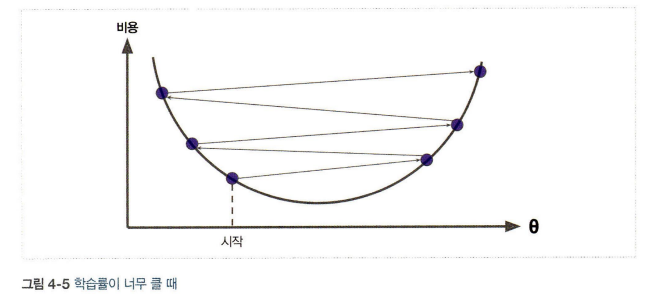

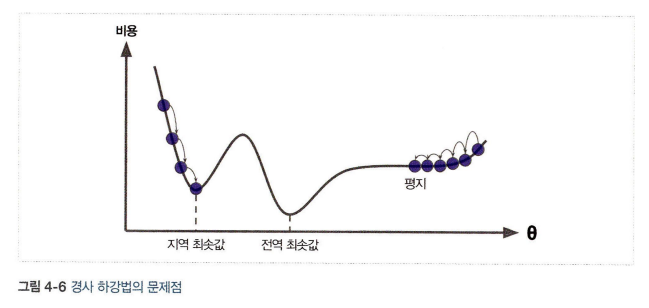

문제점 : 무작위 초기화 때문에 알고리즘이 왼쪽에서 시작하면 전역 최솟값보다 덜 좋은 지역 최솟값에 수렴함. 알고리즘이 오른쪽에서 시작하면 평탄한 지역을 지나기 위해 시간이 오래 걸리고 일찍 멈추게 되어 전역 최솟값에 도달하지 못함

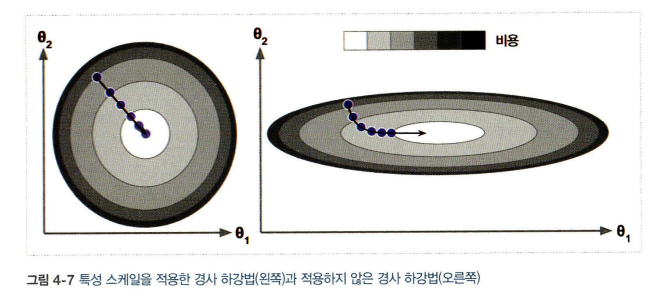

* 왼쪽 : 최솟값으로 곧장 진행하고 있어 빠르게 도달함
* 오른쪽 : 처음에 전역 최솟값의 방향에 거의 직각으로 향하다가 평편한 골짜기를 길게 돌아서 나감. 결국 최솟값에 도달하겠지만 시간이 오래걸림.

###4.2.1. 배치 경사 하강법

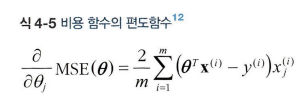

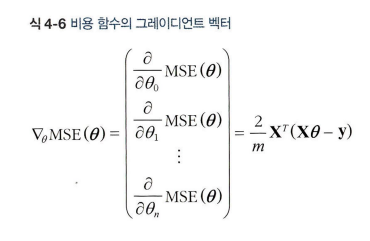

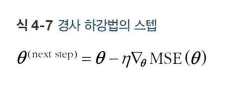

In [10]:
eta = 0.1   # 학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)   # 무작위 초기화

for iteration in range(n_iterations):
  gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
  theta = theta - eta * gradients

In [11]:
theta

array([[4.06799927],
       [2.95944954]])

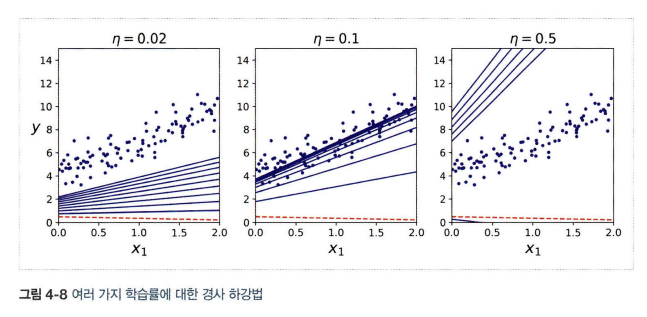

###4.2.2. 확률적 경사 하강법

* 배치 경사 하강법의 가장 큰 문제: 매 스텝에서 전체 훈련 세트를 사용해 그래디언트를 계산한다는 사실
* 훈련 세트가 커지면 속도가 매우 느려짐
* 확률적 경사 하강법: 매 스텝에서 한 개의 샘플을 무작위로 선택하고 그 하나의 샘플에 대한 그레이디언트를 계산
* 다뤄야 할 데이터가 매우 적기 때문에 알고리즘의 속도가 더 빠름
* 반면 확률적이기 때문에 배치 경사 하강법보다 불안정
* 비용 함수가 최솟값에 다다를 때까지 부드럽게 감소하지 않고 위아래로 요동치면서 평균적으로 감소(최적치가 아님)
* 배치 경사하강법보다 지역 최솟값을 건너뛰어 전역 최솟값을 가능성이 높음
* 학습률을 점진적으로 감소시켜 위의 문제 해결 가능

* 담금질 기법 알고리즘과 유사
* 학습 스케줄: 매 반복에서 학습률을 결정하는 함수
* 이때 학습률이 너무 천천히 감소하면 훈련을 일찍 종료하여 지역 최솟값에 머물수도 있음

In [12]:
n_epochs = 50
t0, t1 = 5,50   # 학습 스케줄 하이퍼파라미터

def learning_schedule(t):
  return t0 / (t + t1)

theta = np.random.randn(2,1)   # 무작위 초기화

for epoch in range(n_epochs):
  for i in range(m):
    random_index = np.random.randint(m)
    xi = X_b[random_index:random_index+1]
    yi = y[random_index:random_index+1]
    gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
    eta = learning_schedule(epoch * m + i)
    theta = theta - eta * gradients

epoch : 한 반복에서 m번 되풀이되고, 이때의 각 반복을 의미함

In [13]:
theta

array([[4.08146411],
       [2.92631165]])

In [14]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter = 1000, tol = 1e-3, penalty = None, eta0 = 0.1)  # max_iter : 최대 에포크 횟수. tol : 손실이 줄어들 때까지 실행되는 기준. eta0 : 학습률. penalty : 규제
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [15]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.04158448]), array([2.92886622]))

###4.2.3. 미니배치 경사 하강법

* 미니배치라 부르는 임의의 작은 샘플 세트에 대해 그레이디언트 계산
* 행렬 연산에 최적화된 하드웨어(GPU)를 사용해서 성능을 향상시킴
* 미니배치 경사 하강법은 SGD보다 최솟값에 더 가까이 도달하지만 지역 최솟값에서 빠져나오기 힘들다는 단점이 있음
* 적절한 학습 스케줄을 사용하면 최솟값에 도달 가능

##4.3. 다항 회귀

다항 회귀 : 데이터가 비선형 데이터일 때 각 특성의 거듭제곱을 새로운 특성으로 추가하고 특성을 모두 포함한 데이터셋에 선형 모델을 훈련시키는 기법

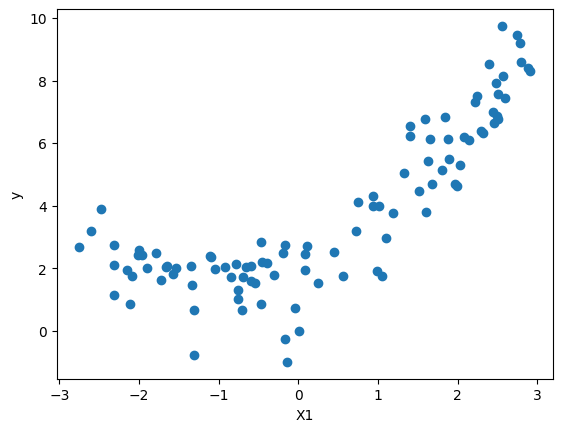

In [16]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m,1)

plt.scatter(X,y)
plt.xlabel('X1')
plt.ylabel('y')
plt.show()

사이킷런의 PolynomialFeatures를 사용해 훈련 데이터 변환

In [18]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([2.29111994])

In [19]:
X_poly[0]

array([2.29111994, 5.24923059])

x_poly는 원래의 특성 x와 이 특성의 제곱 포함

In [20]:
#LinearRegression적용
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.95996792]), array([[0.9975022 , 0.51306174]]))

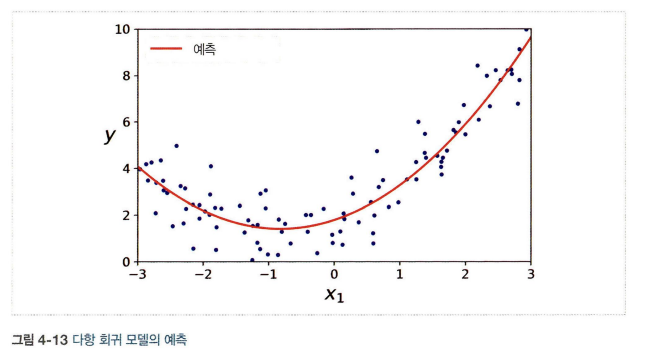

##4.4. 학습 곡선

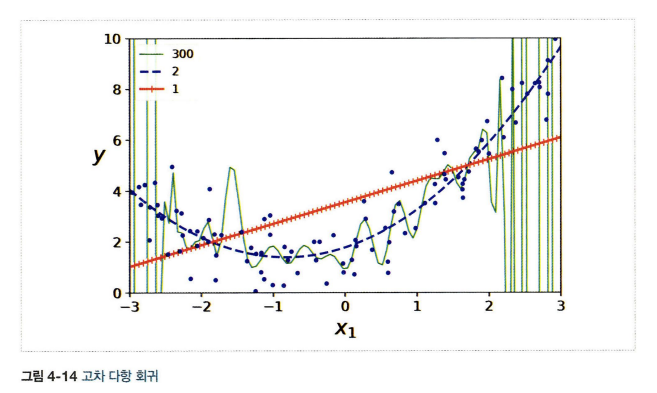

* 고차 다항 회귀 모델 : 훈련 데이터에 과대적합
* 선형 모델 : 과소적합

In [21]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
  train_errors, val_errors = [], []
  for m in range(1, len(X_train)):
    model.fit(X_train[:m], y_train[:m])
    y_train_predict = model.predict(X_train[:m])
    y_val_predict = model.predict(X_val)
    train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

  plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="training set")
  plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="validation set")
  plt.ylim([0, 3.0])
  plt.xlabel('Train Set Size')
  plt.ylabel('RMSE')
  plt.legend()

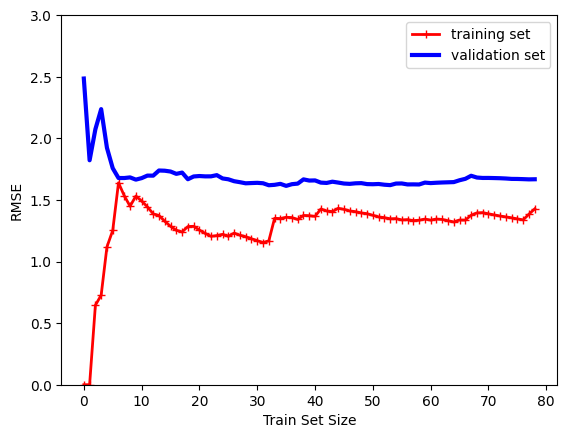

In [22]:
#단순 선형 회귀 모델의 학습 곡선
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

다항 회귀는 특성 사이의 관계를 찾을 수 있음

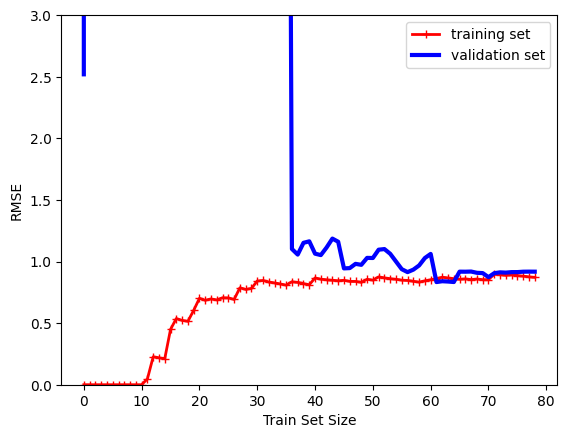

In [24]:
# 같은 데이터에서 10차 다항 회귀 모델의 학습 곡선
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression()),
])
plot_learning_curves(polynomial_regression, X, y)

이전과의 두가지 중요한 차이점
* 훈련 데이터의 오차가 선형 회귀 모델보다 훨씬 낮음
* 두 곡선 사이에 공간이 있음. 이 말은 훈련 데이터에서의 모델 성능이 검증 데이터에서보다 훨씬 낫다는 뜻이고, 이는 과대적합 모델의 특징임. 그러나 더 큰 훈련 세트를 사용하면 두 곡선이 점점 가까워짐

##4.5. 규제가 있는 선형 모델

* 과대적합을 감소시키는 좋은 방법은 모델을 규제하는 것(모델 제한)
* 선형 회귀 모델에서는 보통 모델의 가중치를 제한함으로써 규제를 가함

###4.5.1. 릿지 회귀

* 릿지 회귀 : 규제항 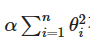가 비용 함수에 추가
* 모델의 가중치가 가능한 한 작게 유지되도록 노력
* 규제항은 훈련 동안에만 비용 함수에 추가
* 모델의 훈련이 끝난 후에는 모델의 성능을 규제가 없는 성능 지표로 평가

* 하이퍼파라미터 alpha는 모델을 얼마나 많이 규제할지 조절
* alpha=0의 릿지 회귀는 선형 회귀와 동일
* alpha의 값이 크면 모든 가중치가 거의 0에 가까워지고 결국 데이터의 평균을 지나는 수평선이 됨

* 릿지 회귀의 비용 함수

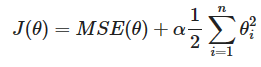

* 편향 theta0는 규제되지 않음
* w를 특성의 가중치 벡터라고 정의할 댸, 규제항은 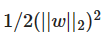와 동일
* 경사하강법에 적용하려면 MSE의 그래디언트에 alphaw를 더함
* alpha가 증가할수록 직선에 가까워짐
* 모델의 분산 감소, 편향 증가
* 선형 회귀와 마찬가지로 릿지 회귀에 정규방정식, 경사 하강법 사용 가능

In [25]:
#정규방정식을 사용하여 릿지 회귀
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]])

array([[5.22929713]])

In [26]:
#확률적 경사 하강법을 사용하여 릿지 회귀
sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([5.21849077])

penalty : 사용할 규제 지정

###4.5.2. 라쏘 회귀

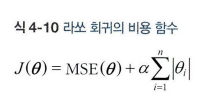

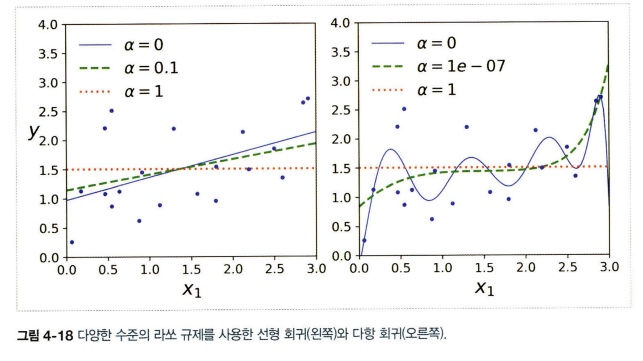

* 중요한 특징 : 덜 중요한 특성의 가중치 제거
* 라쏘 회귀는 자동으로 특성 선택을 하고 최소모델을 만듦

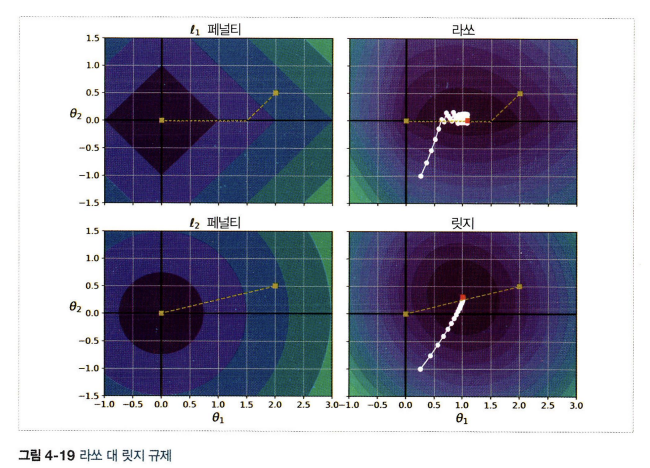

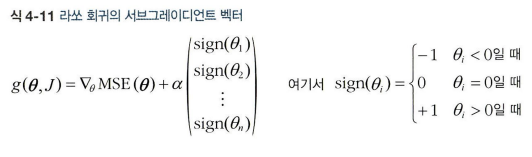

In [27]:
#Lasso 클래스를 사용한 간단한 사이킷런 예제
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([5.19191771])

###4.5.3. 엘라스틱넷

* 엘라스틱넷 : 릿지 회귀와 라쏘 회귀를 절충한 모델
* 규제항은 릿지와 회귀의 규제항을 단순히 더해서 사용하며, 혼합 정도는 혼합 비율 r을 사용해 조절 (r=0 : 릿지 회귀, r=1 : 라쏘 회귀)

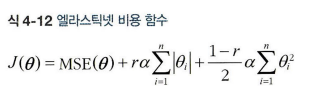

In [28]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X,y)
elastic_net.predict([[1.5]])

array([5.18730687])

###4.5.4. 조기 종료

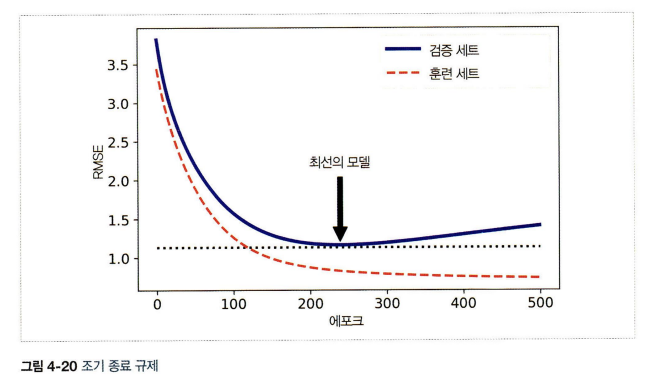

In [29]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
X_train, X_val, y_train, y_val=train_test_split(X, y, test_size=0.2)

# 데이터 준비
poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias = False)),
    ("std_scaler", StandardScaler())
])
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=None, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005)

minimum_val_error = float("inf")
best_epoch = None
best_model = None

for epoch in range(1000):
  sgd_reg.fit(X_train_poly_scaled, y_train)
  y_val_predict = sgd_reg.predict(X_val_poly_scaled)
  val_error = mean_squared_error(y_val, y_val_predict)
  if val_error < minimum_val_error:
    minimum_val_error = val_error
    best_epoch = epoch
    best_model = clone(sgd_reg)

warm_start=True로 지정하면 fit() 메서드가 호출될 때 처음부터 다시 시작하지 않고 이전 모델 파라미터에서 훈련을 이어감

##4.6. 로지스틱 회귀

* 로지스틱 회귀 : 샘플이 특정 클래스에 속할 확률을 추정하는데 널리 사용됨

###4.6.1. 확률 추정

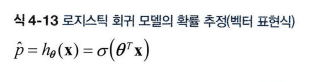

시그모이드 함수

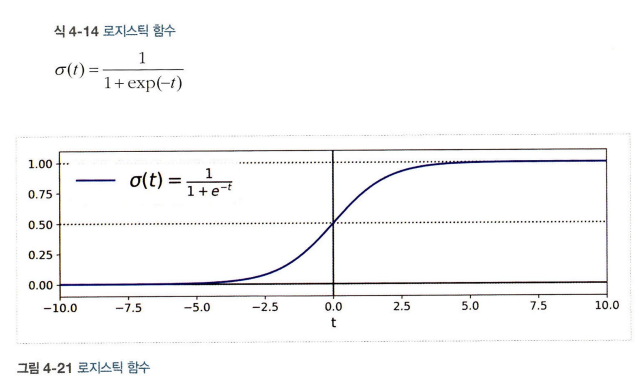

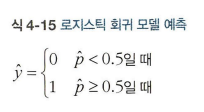

###4.6.2. 훈련과 비용 함수

* 훈련 목적 : 양성 샘플에 대해서 높은 확률을 추정하고 음성 샘플에 대해서는 낮은 확률을 추정하는 모델의 파라미터 벡터 theta를 찾음

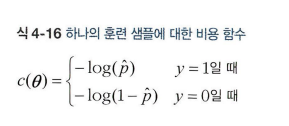

* 전체 훈련 세트에 대한 비용 함수는 모든 훈련 샘플의 비용을 평균한 것

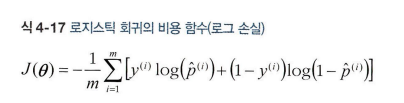

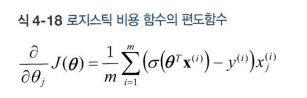

###4.6.3. 결정 경계

In [30]:
# 데이터 로드
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())
X = iris["data"][:,3:]   # 꽃잎의 너비
y = (iris["target"]==2).astype(np.int)   # 1 Iris-Virginica면 1, 그렇지 않으면 0

In [31]:
# 로지스틱 회귀 모델 훈련
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X,y)

LogisticRegression()

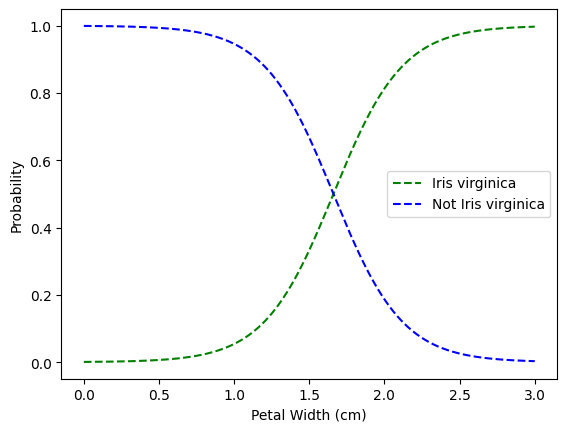

In [32]:
# 꽃잎의 너비가 0~3cm인 꽃에 대해 모델의 추정 확률 계산
X_new = np.linspace(0,3,1000).reshape(-1,1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:,1], "g--", label="Iris virginica")
plt.plot(X_new, y_proba[:,0], "b--", label="Not Iris virginica")
plt.legend()
plt.xlabel('Petal Width (cm)')
plt.ylabel('Probability')
plt.show()

* 약간 중첩되는 부분이 있지만 꽃잎 너비가 2cm 이상인 꽃은 분류기가 Iris-Verginica라고 강하게 확신, 1cm 이하면 아니라고 확신

* 두 극단 사이에서는 분류가 확실하지 않지만 가장 가능성 높은 클래스를 반환

* 양쪽의 확률이 똑같이 50%가 되는 1.6cm 근방에서 결정 경계가 생성됨

In [33]:
log_reg.predict([[1.7],[1.5]])

array([1, 0])

###4.6.4. 소프트맥스 회귀

* 소프트맥스 회귀 : 로지스틱 회귀 모델은 여러 개의 이진 분류기를 훈련시켜 연결하지 않고 직접 다중 클래스를 지원하도록 일반화될 수 있음

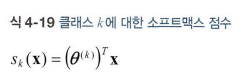

* 각 클래스는 자신만의 파라미터 벡터 theat(k)가 있음. 이 벡터들은 파라미터 행렬 theta에 행으로 저장됨

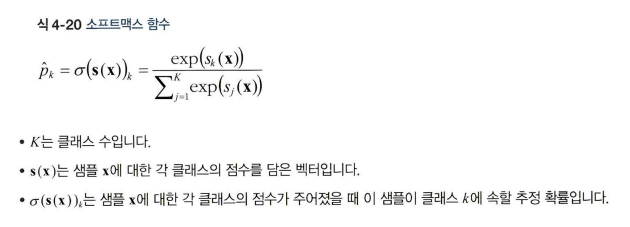

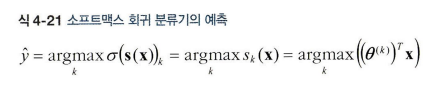

* argmax : 함수를 최대화하는 변수의 값을 반환함

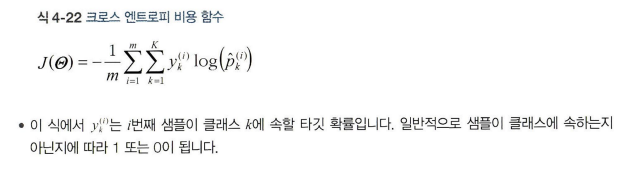

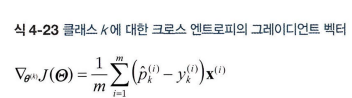

In [36]:
X = iris["data"][:, (2,3)]
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10)
softmax_reg.fit(X,y)

LogisticRegression(C=10, multi_class='multinomial')

In [37]:
softmax_reg.predict([[5,2]])

array([2])

In [38]:
softmax_reg.predict_proba([[5,2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

클래스 사이의 결정 경계는 모두 선형

모든 결정 경계가 만나는 지점에서는 모든 클래스가 동일하게 33%의 추정 확률을 가짐